In [11]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import misc

In [12]:
# import data
#array_from_txtfile = np.loadtxt('my_array.txt')

data = np.array([(-5.0, 51.76405234596766),
                (-4.795918367346939, 45.42306433039972),
                (-4.591836734693878, 41.274448104888755),
                (-3.979591836734694, 26.636216497466364),
                (-3.571428571428571, 20.256806057008426),
                (-2.9591836734693877, 11.618429243797276),
                (-2.7551020408163263, 10.450525068812203),
                (-1.7346938775510203, 1.8480982318414874),
                (-1.3265306122448979, -1.0405349639051173),
                (-0.9183673469387754, -4.614630798757861),
                (-0.7142857142857144, -1.3871977310902517),
                (-0.3061224489795915, -1.9916444039966117),
                (0.1020408163265305, -0.912924608376358),
                (0.7142857142857144, 6.63482003068499),
                (1.1224489795918373, 9.546867459016372),
                (1.7346938775510203, 15.72016146597016),
                (1.9387755102040813, 20.62251683859554),
                (2.5510204081632653, 33.48059725819715),
                (2.959183673469388, 40.76391965675495),
                (3.979591836734695, 66.8997605629381),
                (4.387755102040817, 78.44316465660981),
                (5.0, 99.78725971978604)], dtype=float)
data

array([[-5.        , 51.76405235],
       [-4.79591837, 45.42306433],
       [-4.59183673, 41.2744481 ],
       [-3.97959184, 26.6362165 ],
       [-3.57142857, 20.25680606],
       [-2.95918367, 11.61842924],
       [-2.75510204, 10.45052507],
       [-1.73469388,  1.84809823],
       [-1.32653061, -1.04053496],
       [-0.91836735, -4.6146308 ],
       [-0.71428571, -1.38719773],
       [-0.30612245, -1.9916444 ],
       [ 0.10204082, -0.91292461],
       [ 0.71428571,  6.63482003],
       [ 1.12244898,  9.54686746],
       [ 1.73469388, 15.72016147],
       [ 1.93877551, 20.62251684],
       [ 2.55102041, 33.48059726],
       [ 2.95918367, 40.76391966],
       [ 3.97959184, 66.89976056],
       [ 4.3877551 , 78.44316466],
       [ 5.        , 99.78725972]])

In [13]:
# calculate design matrix A
def matrix(data,n):
    x_list = data[:,0]
    A = np.zeros((len(x_list) ,n))
    for i in range(len(x_list)):
        a_list =[]
        for j in range(n):
             a_list.append(x_list[i]**(n-j-1))
        klist = np.array(a_list)
        A[i] = A[i] + klist
    return A

# LU decomposition
def lu(A):
    #source: https://johnfoster.pge.utexas.edu/numerical-methods-book/LinearAlgebra_LU.html
    #Get the number of rows
    n = A.shape[0]
    U = A.copy()
    L = np.eye(n, dtype=np.double)
    #Loop over rows
    for i in range(n):    
        #Eliminate entries below i with row operations 
        #on U and reverse the row operations to 
        #manipulate L
        factor = U[i+1:, i] / U[i, i]
        L[i+1:, i] = factor
        U[i+1:] -= factor[:, np.newaxis] * U[i]
    return L, U

# Inverse Function for L,U
def inverse(A):
    # Make copies of A & I, AM & IM, to use for row ops
    n = len(A)
    AM = A
    I = np.eye(n)
    IM = I
    indices = list(range(n)) # to allow flexible row referencing ***
    for fd in range(n): # fd stands for focus diagonal
        fdScaler = 1.0 / AM[fd][fd]
        # FIRST: scale fd row with fd inverse. 
        for j in range(n): # Use j to indicate column looping.
            AM[fd][j] *= fdScaler
            IM[fd][j] *= fdScaler
            
        # SECOND: operate on all rows except fd row as follows:
        for i in indices[0:fd] + indices[fd+1:]: 
            # *** skip row with fd in it.
            crScaler = AM[i][fd] # cr stands for "current row".
            for j in range(n): 
                # cr - crScaler * fdRow, but one element at a time.
                AM[i][j] = AM[i][j] - crScaler * AM[fd][j]
                IM[i][j] = IM[i][j] - crScaler * IM[fd][j]
    return IM

In [14]:
# Calculate the inverse of (ATA+λI) with LU decomposition, (ATA+λI)-1 ATb
def LSE( data, n, l):
    A = matrix(data,n)
    b = data[:,1]
    AT = A.transpose()
    s = AT.shape[0]
    Matrix = np.dot(AT,A) 
    Matrix += np.eye(s)*l
    L, U = lu(Matrix)
    L_inv = inverse(L)
    U_inv = inverse(U)
    Matrix_inv = np.dot(U_inv,L_inv)
    first = np.dot(Matrix_inv,AT)
    X = np.dot(first, b)
    #plot(data,A,X)
    #error = sum(abs(np.dot(A,X)-b))
    error = np.sum(np.square(np.dot(A,X)-b))
    #print("LSE:")
    #print_out(X,n)
    #print("Total error: ",error)
    return A, X, error

In [15]:
# Newton's method
def get_loss_value(A, X, b):
    return np.sum(np.square(np.dot(A,X)-b))

def NewtonsMethod_calculate(A,b, tolerance=0.000001):
    m,n=A.shape
    #initial parameters x
    x0=np.random.rand(n,1)
    while True:
        x1 = x0 - inverse(2*A.T@A )@(2*A.T@A@x0-2*A.T@b)
        t = abs(np.sum(np.square(x1 - x0))/n)
        if t < tolerance:
            break
        x0 = x1
        
    error = get_loss_value(A, x0, b)
    return x0, error


In [16]:
# Newton's method main
def newton_method(data , n):
    A = matrix(data,n)
    b = data[:,1]
    b= b.reshape(len(b),1)
    X0 , error = NewtonsMethod_calculate(A, b)
    print("Newton's method:")
    X0 = X0.reshape(X0.shape[0],)
    #print_out(X0,n)
    #print("Total error: ",error)
    #plot(data,A,X0)
    return A, X0, error

In [17]:
def print_out(X,n):
    lst = []
    for i in range(n-1):
        lst.append(str(X[i])+'X^'+str(n-i-1))
    if X[-1] >0:
        lst.append(str(X[-1]))
        out_str = " + ".join([str(_) for _ in  lst])
        out = "Fitting line: "+ out_str
    elif X[-1] <0:
        out_str = " + ".join([str(_) for _ in  lst])
        out = "Fitting line: "+  out_str +' ' +str(X[-1])
    else:
        out_str = " + ".join([str(_) for _ in  lst])
        out = "Fitting line: "+ out_str
    print(out)


In [18]:
# Main function
#array_from_txtfile = np.loadtxt('my_array.txt')

def main_function(data, n, l):
    
    A_lse, X0_lse, error_lse = LSE( data, n, l)
    
    A_new, X0_new, error_new = newton_method(data,n)
    fig, ax = plt.subplots(2)
    x_train, y_train = data[:,0], data[:,1]
    out1 = np.dot(A_lse, X0_lse)
    ax[0].plot(x_train, y_train, '.')
    ax[0].plot(x_train, out1 , 'r-')
    out2 = np.dot(A_new,X0_new)
    ax[1].plot(x_train, y_train, '.')
    ax[1].plot(x_train, out2 , 'r-')
    
    
    print("LSE:")
    print_out(X0_lse,n)
    print("Total error: ",error_lse)
    
    
    print("Newton's method:")
    print_out(X0_new,n)
    print("Total error: ",error_new)


Newton's method:
LSE:
Fitting line: 3.3296134007540408X^1 + 23.936171703191384
Total error:  14948.665201244217
Newton's method:
Fitting line: 3.511767478424024X^1 + 27.26778475647258
Total error:  14707.607506994382


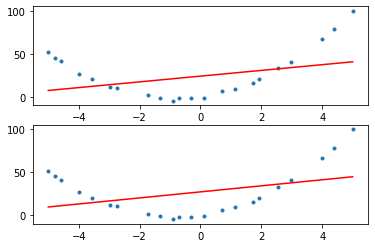

In [19]:
main_function(data, 2, 3)

Newton's method:
LSE:
Fitting line: 0.7269544088048294X^2 + 0.060370119695057414X^1 + 0.042238388942893716
Total error:  19466.98618558874
Newton's method:
Fitting line: 3.015697727502105X^2 + 4.879376775325803X^1 -0.20824982979606588
Total error:  25.427826062945385


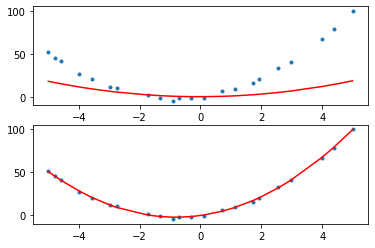

In [22]:
main_function(data, 3, 10000)